# Practical Implementation: Unsupervised Learning - Word vectors with word2vec algorithm -

In this lecture, we are going to present the word2vec algorithm, introduced by [Mikolov et al. 2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). It is one of the most successful ideas for learning word vectors. 

In [0]:
# Import basic Modules
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plots 
from IPython.display import Image # for showing graphs from the lectures

# Presentation of the Coursework

* Let's start with the following small quiz: [here](https://forms.gle/cQnNGaiLFsS7gh8q8)
* If you have any question about the coursework, feel free to send us an email.

# 1. Load the data and preprocess it. 

## 1.1 A simple example

The first step of each NLP problem is to turn words into integers via a word2idx dictionary.

Q1. Let's consider the following sentences:

  * Word2vec is an amazing algorithm
  * Word2vec aims to create an embedding matrix
  * Glove is an other way of creating an embedding matrix

Create a dictionary to map the words into integers. Show the word2idx dictionary.

In [0]:
sentence_1 = "Word2vec is an amazing algorithm".split()
sentence_2 = "Word2vec aims to create an embedding matrix".split()
sentence_3 = "Glove is an other way of creating an embedding matrix".split()
sentences = [sentence_1, sentence_2, sentence_3]

{'Glove': 11,
 'Word2vec': 1,
 'aims': 6,
 'algorithm': 5,
 'amazing': 4,
 'an': 3,
 'create': 8,
 'creating': 15,
 'embedding': 9,
 'is': 2,
 'matrix': 10,
 'of': 14,
 'other': 12,
 'to': 7,
 'way': 13}

## 1.2 Load the dataset

Q2. Load the RedditNews data, extract the news from the **News** column and store them in a list called `news`




In [0]:
# Import data
data = pd.read_csv("./RedditNews.csv")

'A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.'

In [0]:
MAX_VOCAB = 9999

Q3. Using `Tokenizer` from `tensorflow.keras.preprocessing.text`
 perform the preprocessing steps to turn the list of news into a list of integers.

Q4. Get the word to index dictionary called `word_index` from `tokenizer.word_index`. Keep only the pairs of (k,v) for which `v < MAX_VOCAB`. Add to your dictionary the tokens 'START' and 'END'.  

Q5. Create the dictionary `index_word` to reverse the dictionary `word_index`. (i.e, the dictionary `index_word` will map each index to the corresponding word)

Q5. Shuffle your list of sequences. And for each sequence in your list of sequences of integers, add the index of 'START' at the beginning and the index of 'END' at the end of the sequence.

For instance, if the indexes of the tokens 'START' and 'END' are 0 and MAX_VOCAB

We want the sequence [2, 54, 23, 65, 134] to become [0, 2, 54, 23, 65, 134, MAX_VOCAB]

Let's call the list of sequences : `sequences`


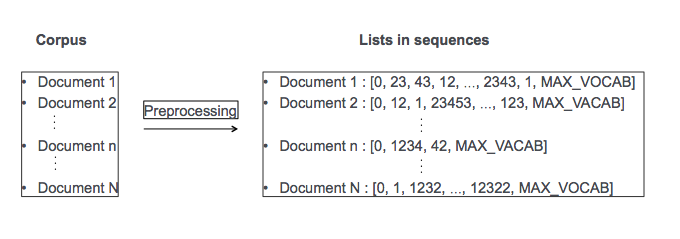

In [0]:
Image(filename='./images/sequences.png',  width=700) 

## 1.3 Limitations of one hot vectors

**Definition**: We call an **Embedding Matrix** any matrix of shape $(V, D)$ where each row $i$ is a D-dimensional vector representing the word $i$ in the word_index dictionary. 

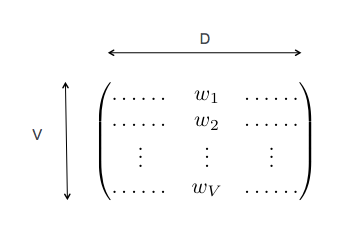

In [0]:
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_6/images/embedding.png',  width=500) 

We have seen one way of encoding words into D-miensional vectors: **One hot encoding** (in that case D = V) since we represente each word by a vector of size V with zeros everywhere except for the position of its index where we put 1. 

Why is it suboptimal to take the one hot encoding vectors as rows of the embedding matrix?

Let's take a simple example of three words: "finance", "economy" and "biology". 

We expect "finance" and "economy" to be closer to each other (in some sense we should define) than "finance" and "biology" or "economy" and "biology". 

However, if we represent the one hot vectors of these three words:

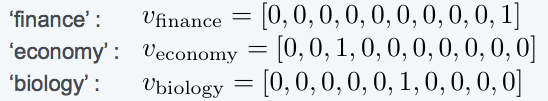

In [0]:
Image(filename='./images/onehot.png',  width=500) 

The three vectors $v_{\text{finance}}, v_{\text{economy}}$ and $v_{\text{biology}}$ are orthogonals.

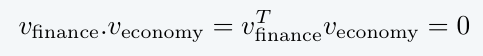

In [0]:
Image(filename='./images/ortho.png',  width=500) 

We need to find a way to encode a notion of **similarity** in the vectors. 

Moreover, each one hot vector is of size $V*, which is huge ! 

We want each word to be encoded into a vector in $\mathbb{R}^D$ with $D<<V$ where each dimension of the vector encodes an aspect of the sense of the word. 

To sum up: **closer words should have similar word vectors**

# 2. The word2vec algorithm - Step by step -

## 2.1 Introduction

In the coursework, a shallow network is trained to predict the next word based on a corpus.

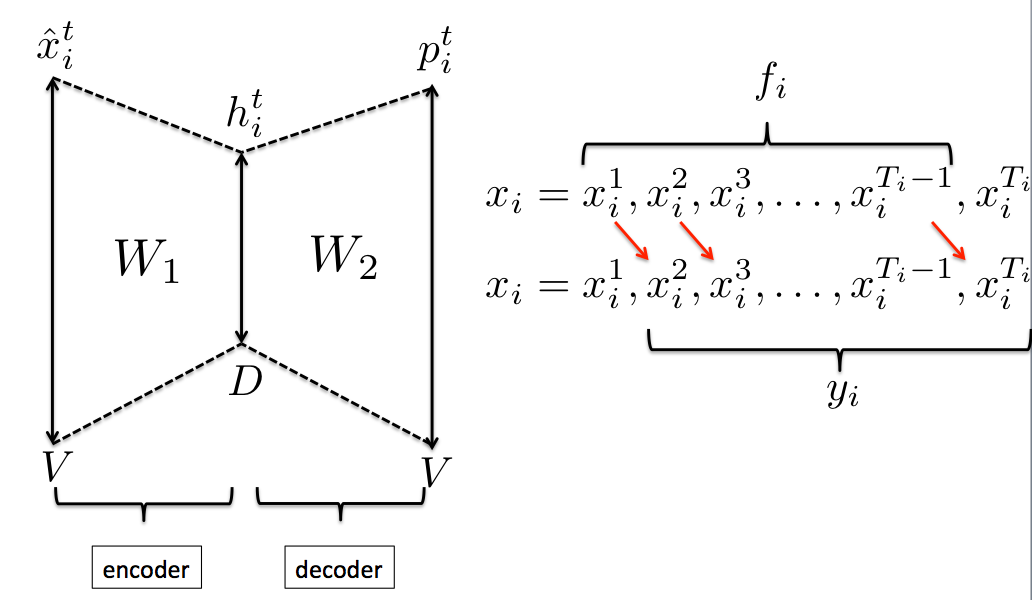

In [0]:
Image(filename='./images/coursework.png',  width=700) 

The matrices $W_1$ and $W_2^T$ are matrices of shape $(V, D)$. 

After the training process, these matrices can play the role of the embedding matix, as they are trained to map a word to its closest next neigbour. 

The word2vec algorithm is a generalisation of this concept. It learns to map a word to a wide spectrum of neighbours. 

The word2vec algorithm takes its inspiration from an English lunguist, named *John Rupert Firth*, known for his famous quotation:

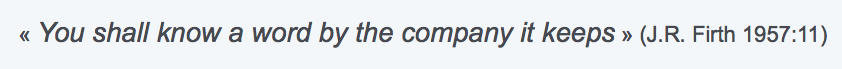

In [0]:
Image(filename='./images/JRF.png',  width=700) 

So, we should look at the **context** of a word to build its representation (encoding). 

These examples are taken from the [RedditNews](https://www.kaggle.com/aaron7sun/stocknews) dataset:

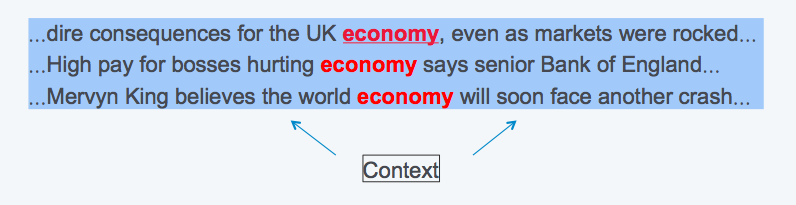

In [0]:
Image(filename='./images/context.png',  width=700) 

In this example, the word **economy** should be understood from its context in each sentence. 

## 2.2 Get the context of words

Q6. Create a function called `get_context_words` which returns the list of context words (as integers in the `word_index` dictionary).

The function will have 3 parameters: 

* **position**: an int representing the position of the center word (the word for which we aim to output the context) 
*  **sequence**= a list of int representing the sequence of integers (index words)
* **context_size** : an int representing half the number of words in the context.

The function should output the list of context words as integers

For instance in the following example, the function should output the list [45, 64, 675, 235, 76, 443]


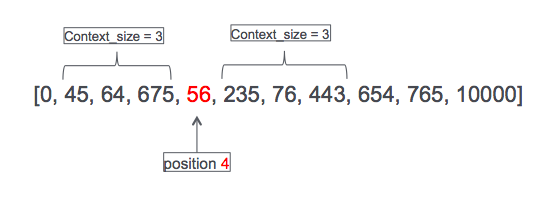

In [0]:
Image(filename='./images/example.png',  width=700) 

## 2.3 Creating the pairs (input, context)

Let's go back to the architecture of the coursework. 

Let's consider two successive words in the corpus "Financial markets". 

Let's suppose the index of "Financial" is 43 and the index of markets is 65. 

The one hot vector representing "Financial" will be feeded to the neural network, we will then compare it to the true target, which is the one hot vector associated with the work market. 

As V is huge. It's very unlikely that after any number of gradient descent iterations, we end up with the right prediction

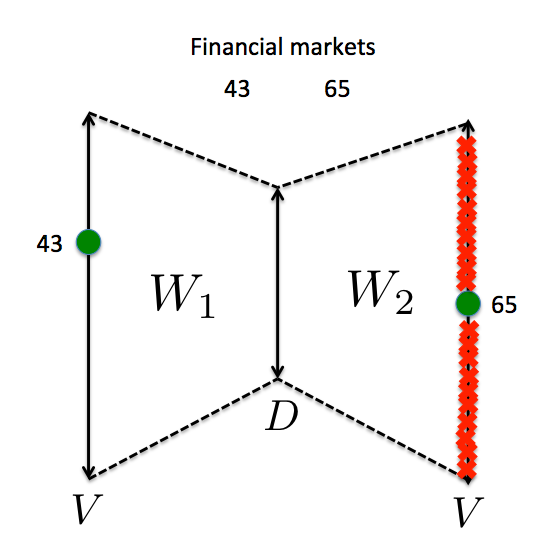

In [0]:
Image(filename='./images/coursework2.png',  width=500) 

Instead of this, we use the concept of **negative sampling**. 

Let's go back to our example

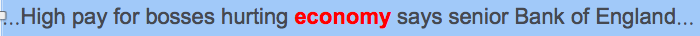

In [0]:
Image(filename='./images/example2.png',  width=700) 

Let's take a `context_size` equal to 3.

Let the index of **economy** ($\text{idx}_{\text{economy}}$) be our center word. 

By using the `get_context_words` function, we will output the following context:
$[\text{idx}_{\text{for}}, \text{idx}_{\text{bosses}}, \text{idx}_{\text{hurting}}, \text{idx}_{\text{says}}, \text{idx}_{\text{senior}}, \text{idx}_{\text{Bank}}]$

We can than create these couple of (input, context) which are coherent (as they come from the training corpus):

* ($\text{idx}_{\text{economy}}, \text{idx}_{\text{for}}$)
* ($\text{idx}_{\text{economy}}, \text{idx}_{\text{bosses}}$)
* ($\text{idx}_{\text{economy}}, \text{idx}_{\text{hurting}}$)
* ($\text{idx}_{\text{economy}}, \text{idx}_{\text{says}}$)
* ($\text{idx}_{\text{economy}}, \text{idx}_{\text{senior}}$)
* ($\text{idx}_{\text{economy}}, \text{idx}_{\text{Bank}}$)

We can then sample a **fake** input, like the word "music", we will end up with the following incoherent couples of (input, context):

* ($\text{idx}_{\text{music}}, \text{idx}_{\text{for}}$)
* ($\text{idx}_{\text{music}}, \text{idx}_{\text{bosses}}$)
* ($\text{idx}_{\text{music}}, \text{idx}_{\text{hurting}}$)
* ($\text{idx}_{\text{music}}, \text{idx}_{\text{says}}$)
* ($\text{idx}_{\text{music}}, \text{idx}_{\text{senior}}$)
* ($\text{idx}_{\text{music}}, \text{idx}_{\text{Bank}}$)


We can then create a dataset of of size 2*context_size of positive and negative samples


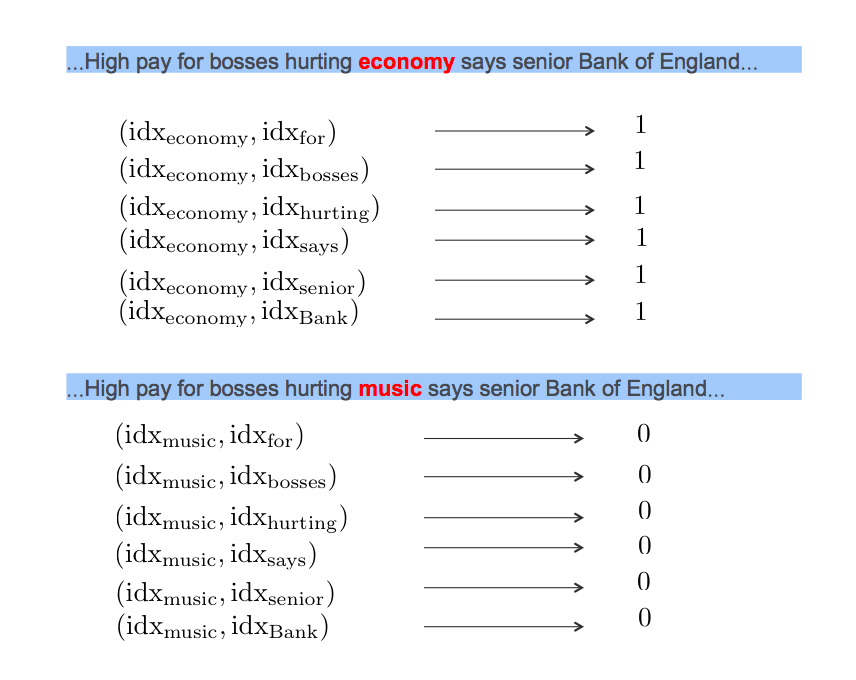

In [0]:
Image(filename='./images/negative_samples.png',  width=700) 

In order to sample the fake context word, we use the following discrete distribution over the indexes of the vocabulary.

For each index $i_w$ of the word w, let $N(i_w)$ be the number of times the word w appears in the corpus. 

We define the **negative sampling distribution** n as follows: 

\begin{equation}
  \forall i_w \in \{1, \dots, V \} \quad n(i_w) = \frac{N(i_w)^{0.75}}{\sum\limits_{i_{w'} = 1}^V N(i_{w'})^{0.75}}
\end{equation}

Q6. Create the function called `get_negative_sampling_distribution` which takes as input:

* sequences : the list of list of integers
* V : the vocabulary size

The function should output the list $[n(i_w) \ \text{for} \ {i_w \in \{1, \dots, V \}}]$

## 2.4 The Forward Propagation

Let's consider the following shallow neural network. 

* A one hot vector $\hat{x}$ is feeded to the neural network. 
* A first **linear** transformation maps $\hat{x}$ to the D-dimensional vector $h$ as follows:
\begin{equation}
h = W_1^T \hat{x}
\end{equation}
* A second transformation maps the hidden vector $h$ to $p$ as follows:
\begin{equation}
p = \text{sigmoid}(W_2^T h)
\end{equation}

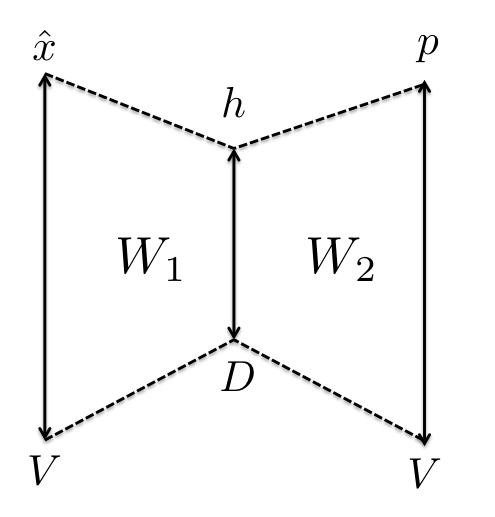

In [0]:
Image(filename='./images/forward.png',  width=400) 

Let $o \in \{1, \dots, V \}$, let $x$ be the position of 1 in the one hot vector $\hat{x}$ and $p_o$ be the o-th element of $p$

Let $W_1[1], \dots, W_1[V]$ be the rows of the matrix $W_1$

Let $W_2[1], \dots, W_2[V]$ be the columns of the matrix $W_2$




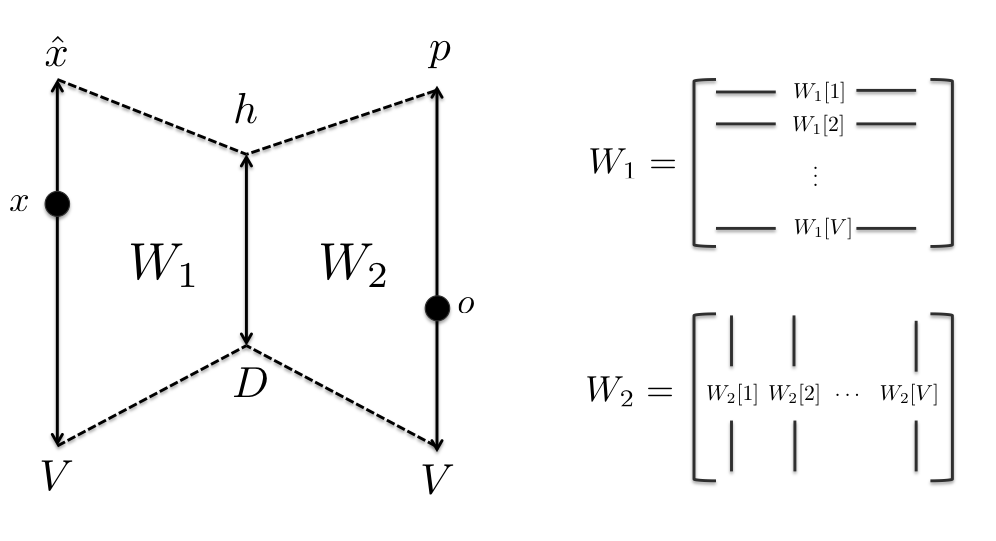

In [0]:
Image(filename='./images/forward2.png',  width=700) 

Q7. Show that:

\begin{equation}
p_o = \text{sigmoid}(W_1[x]^T W_2[o])
\end{equation}

As we have used the sigmoid activation function, $p_o$ represents the probability of the output word of index $o$ being associated to a positive target given the context word $\hat{x}$ (i.e the context word of index $x$). 

Done on the board

Let's take the example with the context word $x$ being the index of economy $\text{idx}_{\text{economy}}$. With this example, we created 6 samples associated to a positive target as shown in the figure below:


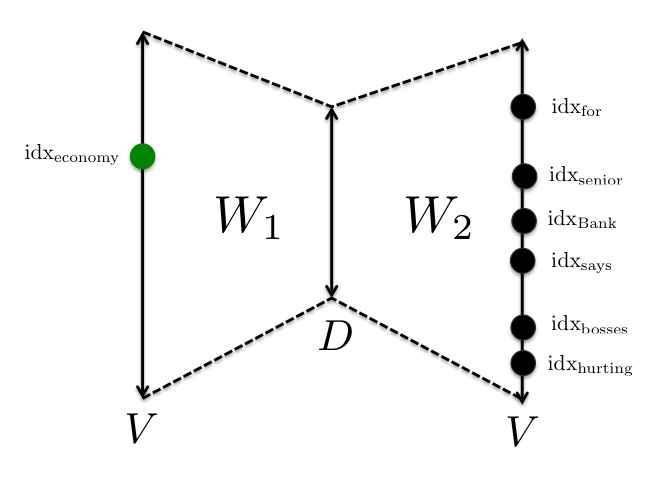

In [0]:
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_6/images/positive_targets.png',  width=700) 

With the fake index $\text{idx}_{\text{music}}$, we have also create 6 samples associated to a negative target as show in the figure below:

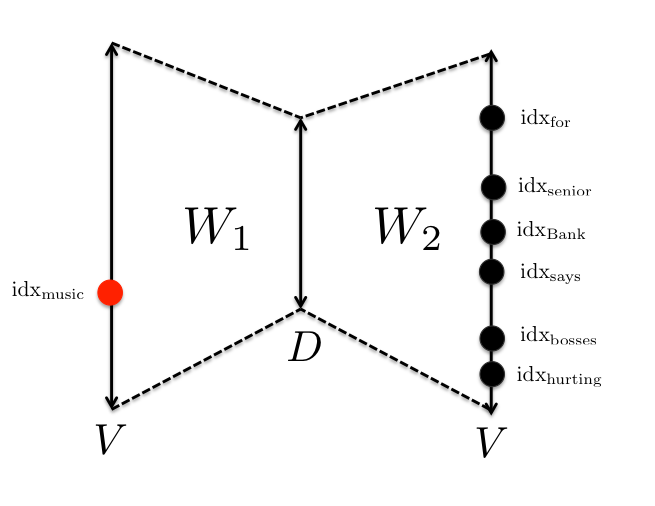

In [0]:
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_6/images/negative_targets.png',  width=700) 

Let $\mathcal{C} = \{\text{idx}_{\text{for}}, \text{senior}_{\text{Bank}}, \text{idx}_{\text{says}}, \text{idx}_{\text{bosses}}, \text{idx}_{\text{hurting}}\}$ be the indexes of the context

Q8. Show that the loss function associated to the 12 samples created before is the following:

\begin{equation}
J = - \sum\limits_{c \in \mathcal{C}} \left[ \log(\sigma (W_1[\text{idx}_{\text{economy}}]^T W_2[c])) +  \log(1 - \sigma (W_1[\text{idx}_{\text{musix}}]^T W_2[c])) \right]
\end{equation}

Where $\sigma$ stands for the sigmoid function. 


Hint: 

* Remember that if you have N training data for a binary classification problem, if $p_n$ represent your predictions for the sample $n$ and $t_n$ your associated target, then the loss function is the following:
\begin{equation}
J = \frac{1}{N} \sum\limits_{n=1}^N  (t_n \log(p_n) + (1 - t_n) \log(1 - p_n))
\end{equation}




## 2.5 The Backward Propagation

As you have noticed, only few parameters were involved in the computation of the loss function. 

* The rows $W_1[\text{idx}_{\text{economy}}]$ and $W_1[\text{idx}_{\text{music}}]$
* The colonms $W_2[c]$ for all $c \in \{\text{idx}_{\text{for}}, \text{senior}_{\text{Bank}}, \text{idx}_{\text{says}}, \text{idx}_{\text{bosses}}, \text{idx}_{\text{hurting}}\}$ 

So we only need to update these two rows of $W_1$ and 6 columns of $W_2$.

By taking the derivative of the loss function with repsect to the previous rows and columns, we get the following gradients:

* If $\text{idx} = \text{idx}_{\text{economy}}$
\begin{align}
  \nabla_{W_1[\text{idx}_{\text{economy}}]} J &= \sum_{c \in \mathcal{C}} (\sigma (W_1[\text{idx}_{\text{economy}}]^T W_2[c]) - 1) W_2[c] \\
   \forall c \in \mathcal{C} \quad \nabla_{W_2[c]} J &= W_1[\text{idx}_{\text{economy}}] (\sigma (W_1[\text{idx}_{\text{economy}}]^T W_2[c]) - 1) \\ 
\end{align}




* If $\text{idx} = \text{idx}_{\text{music}}$
\begin{align}
  \nabla_{W_1[\text{idx}_{\text{music}}]} J &= \sum_{c \in \mathcal{C}} \sigma (W_1[\text{idx}_{\text{music}}]^T W_2[c]) W_2[c] \\
   \forall c \in \mathcal{C} \quad \nabla_{W_2[c]} J &= W_1[\text{idx}_{\text{music}}] \sigma (W_1[\text{idx}_{\text{economy}}]^T W_2[c]) \\ 
\end{align}

Q8. Define a function `stochastic_gradient_descent` that updates the row of $W_1$ and the columns of $W_2$ and outputs the loss function:

The function will take as parameters:

* input_word : an int representing the center word (might be the good one or a fake center word)

* targets : list of int representing the context words

* label : an int taking two possible values: 1 if the center word is the real center word, 0 if it's a fake center word. 

* learning_rate: a float representing the learning rate of the SGD

* W_1

* W_2

The function will perform one iteration of Stochastig Gradient Descent by calculating the cost and updating the weights




# 3. Creating the word vectors

## 3.1 Configuring the hyperparameters

Q9. Define the `context_size`, the `learning_rate`, the number of epochs `epochs`, the embedding dimension `D`

(Make the learning rate decrease linearly after each epoch)

Q10. Using the function `get_negative_sampling_distribution` define earlier, create the vector of size $V$ representing the distribution from which we are going to sample fake center words

## 3.2 The learning process

Q11. Perform the learning.


**The pseudo code:**

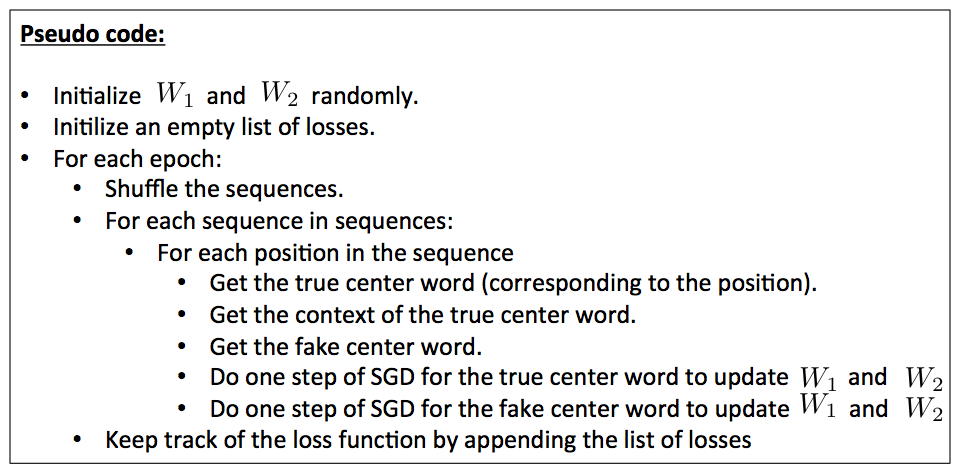

In [0]:
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_6/images/pseudo_code.png',  width=700) 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.21 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.22 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.23 %
epoch : 19/20   progression : 93.24 %
epoch : 19/20   progression : 93.24 %
epoch : 19/20   progression : 93.24 %
epoch : 19/20   progression : 93.24 %
epoch : 19/20   progression : 93.24 %
epoch : 19

Q12. Plot the loss function at the end of each epoch.

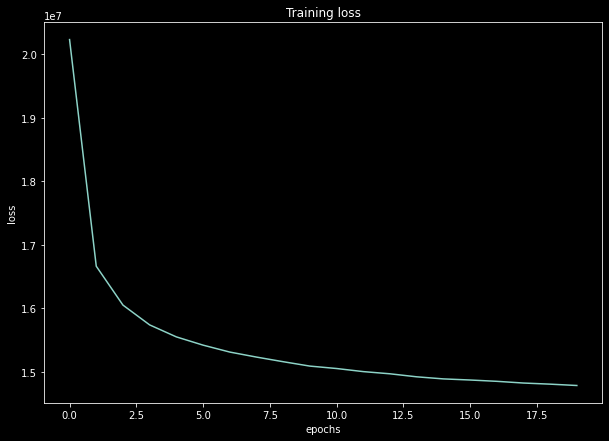

## 3.3. Analogies

We want to use the matrices $W_1$ or $W_2^T$ as an embedding matrix $W_e$ of shape $(N, D)$ 

You can also define $W_e = \frac{W_1 + W_2^T}{2}$

Now, each word of index $\text{idx}_{\text{word}}$ will be encoded into the D dimensional vector $W_e[\text{idx}_{\text{word}}]$

Q13. Define a function, called `analogy`. This function will take three words as inputs $w_1$, $w_2$, $w_3$.

Let $v_1, v_2, v_3$ be the embeddings of $w_1, w_2, w_3$ using the embedding matrix of your choice, create the vector:

we want to compute the vector $v_4$ such that:

\begin{equation}
v_1 - v_2 = v_3 - v_4
\end{equation}

i.e, 

\begin{equation}
v_4 = v_3 + v_2 - v_1
\end{equation}

The function will then compare the vector $v_4$ to all the rows of $W_e$ to find the closest embedding vector $v*$ in term of cosine distance. 

The function will output the word associated the vector $v^*$.

For instance, if we give the function the three words "France", "Paris", "Spain".

Since the function will find the closest word vector to the vector $v$ such that $v_{\text{France}} - v_{\text{Paris}} = v_{\text{Spain}} - v$ we expect the function to output "Madrid".

It just means that: **France is to Paris what Spain is to ...**


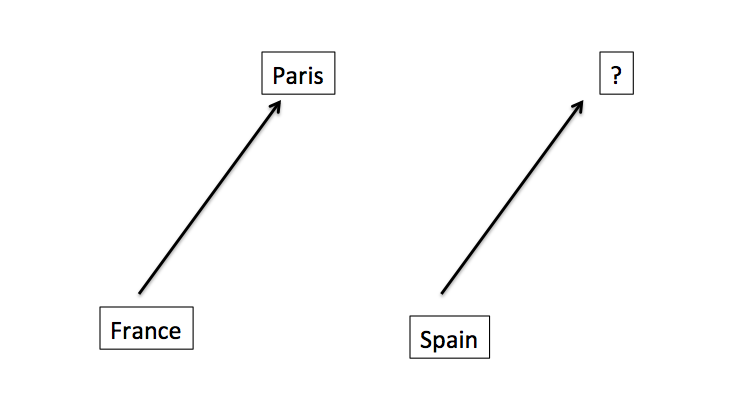

In [0]:
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_6/images/analogy.png',  width=700) 

In [0]:
analogy("France", "Paris", "Spain")

madrid


# Summary:



In this programming session, we learned:
  * How to preprocess text data by creating a list of sequences of integers. 
  * We learned how to create meaningful D-dimensional representations of words by implementing the **word2vec** algorithm.
  
We will see in the next lecture how we can use these embeddings to create much powerful neural network architectures than the one we have seen so far. 